## Connecting to the Database

In [2]:
pip install psycopg2-binary;

  Using cached psycopg2_binary-2.8.6-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import psycopg2

In [4]:
# Put the password in 
PGHOST = 'tripdatabase.cmaaautpgbsf.us-east-2.rds.amazonaws.com'
PGDATABASE = ''
PGUSER = 'postgres'
PGPASSWORD = 'Josh1234'

In [5]:
# Database Context Manager
try:   
    # Set up a connection to the postgres server.    
    conn = psycopg2.connect(user = PGUSER,
                            port = "5432",
                            password = PGPASSWORD,
                            host = PGHOST,
                            database = PGDATABASE)
    # Create a cursor object
    cursor = conn.cursor()   
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Connection Success:", record,"\n")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)

Connection Success: ('PostgreSQL 12.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',) 



## Trip Table Cleaning I: Removing Outliers - Trip Duration
We will be using a basic definition of an outlier in this project. An outlier will be defined as any value that is more than 3 times the standard deviation. The trip table has 111M rows in it so unfortunately we cannot directly take the mean and std of the tripduration column because it would take hours to execute. To overcome this we will use a sampling distribution to estimate the population mean and std.

In [6]:
# Possible Question: Evolution of ride length over time

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Queries
import importlib

In [59]:
importlib.reload(Queries)

<module 'Queries' from '/root/Citi-Bike-Expansion/Queries.py'>

To get a feeling for how the trip duration values are distributed, let's sample 1M rows

In [50]:
sample_data = Queries.get_random_100k_rows(conn,shuffles=10)   # Get random samples 100K rows at a time

In [14]:
sample_data['tripduration'].describe()

count    1000000.000000
mean          16.173446
std          216.786921
min            1.000000
25%            6.000000
50%           10.000000
75%           18.000000
max       134941.000000
Name: tripduration, dtype: float64

The mean value of the trip duration column is 16m, but it has a standard deviation of 222m which is nearly 4 hours. Additionally, the 75 percentile of our data is 18m. It is clear that there are trips that are completely skewing our data. To put it in persective, if we use our original definition of an outlier then only trips over 12 hours would be considered outliers. Because the data is so badly skewed the standard deviation is unreliable to help find outliers.

Our original outlier identification idea was based on the empirical rule that states 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean. Since our standard deviation is unreliable we will rip off the underlying idea behind the empirical rule, but with quantiles since they seem to be representative of real life. Using quantiles, 99% of our data should be between the 0.5th and the 99.5th percentile. Anything above or below those percentile values will be considered outliers

In [15]:
sample_data.tripduration.quantile(0.005), sample_data.tripduration.quantile(0.995)

(1.0, 94.0)

Things to Mention
- All the trips that are slightly above 1.5 hrs aren't necessarily invalid trips. However, the trips that have a high likelihood of being invalid are above 1.5 hrs. Why? Citibike isn't a service targetted towards long distance rides, which can be seen in their pricing models. The annual membership allows unlimited rides that are capped at 45m. Their day pass allows unlimited rides that are capped at 30m. And a single ride is 3 for 30m. With these finacial thresholds in place, it makes sense why the majority of trips are beneath them. In fact, there is no incentive for a person to keep a bike out for significantly longer than the threshold. If you need the bike for 90m than an as annual rider you park the bike at 45m and then take another bike for the other 45m and not have to pay the extra 6.75 (unless you rode to a place where there aren't any stations to park or the stations have very limited bikes and you don't want to risk your bike being taken and being stranded).
- The data is 'sensitive' to quantile changes. Example the 99.5th quantile is 94m the 99th is 62m and the 98th is 46m.
- Although there is only one sample of 1M rows taken, no matter how many times you sample from all the trips the lower quantile is 1 and the upper quantile is close to 96. The reason that I ommitted the many times I sampled was because the samples take a long time to execute*

In [32]:
Queries.delete_duration_outliers()

TypeError: delete_duration_outliers() missing 1 required positional argument: 'conn'

## Trip Table Cleaning II: Removing Time Errors - Start Time After End Time

Anytrip with a starttime that was greater than an endtime is an error and will get deleted. It is possible that the two values were just swapped. The cost of swapping them is more expensive than it is worth and it's better to just remove them. The operations of the swap are:
- Find the incorrect values
- Move them to a temporary table with the correct order
- Delete them from the original table
- Reinsert them 

In [74]:
data = Queries.find_time_swaps(conn)

In [75]:
data.shape

(201, 8)

From the first step there are barely over 200 incorrectly timed trips returned, continuing to the other steps isn't worth it for such little data. It's less expensive to delete them. 

In [ ]:
Queries.delete_time_swaps()

## Trip Table Cleaning III: Removing Outliers - Speed
In this section we are going to remove trips whose speeds (MPH) are physically unlikely. Luckily, we have a reference from CitiBike on what a speed outlier might look like. According to them their pedal assisted e-bikes can go up to 18 MPH. In the sport of cycling, although not on a pedal assisted bike, a reasonably experienced cyclist can reach over 19 MPH. Using a nicer whole number, 20 MPH is the cutoff and anything over that is most likely an outlier. We can't determine outliers on the lower end because of round trips. These trips start and end at the same station and would have a distance of zero resulting in a speed of zero.  

In [83]:
sample_data = Queries.get_random_100k_rows(conn,distance=True, shuffles=10)

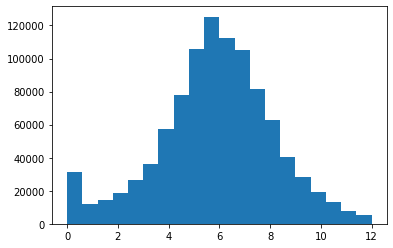

In [161]:
plt.hist(regular.MPH.astype(float), bins=20, range=(0,12));